In [1]:
import sys
#sys.path.append("..") # only used if we can a notebook folder?

is_in_colab = 'google.colab' in sys.modules

if is_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.insert(0,'/content/drive/MyDrive/nlp_question_answer_project')

    %cd /content/drive/MyDrive/nlp_question_answer_project/

In [2]:
%%capture
!pip install -r requirements.txt

# 1.2 Binary Question Classification

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer

from enum import Enum

import fasttext
import fasttext.util

import torch
from torch import nn
import torch.optim as optim

import torchnlp
import torchnlp.nn

from sklearn.metrics import accuracy_score
import compress_fasttext
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from utils.dataset import load_datasets_by_language, save_dataset, load_dataset

from typing import List, Set, Dict, Tuple, Optional

C:\ProgramData\Anaconda3\envs\nlp_qa\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
class Annotation_error(Enum):
    UNANSWERED = -1
    BAD_TOKENIZATION_OR_DATA = -2
    IGNORED = -3
    # Or the span e.g. (4,9)

In [4]:
languages = ["en", "fi", "ja"] # Languages which will actually be used.

In [5]:
language_code_to_language = { "en": "english", "fi": "finnish", "ja": "japanese" }
language_models = { "en": {}, "fi": {}, "ja": {} } # here we store all the models for each of the 3 languages

In [6]:
path_to_training_set   = "data/train_set_stanza.pkl"
path_to_validation_set = "data/validation_set_stanza.pkl"

In [7]:
path_to_raw_training_set   = "data/raw_train_set.pkl"
path_to_raw_validation_set = "data/raw_validation_set.pkl"

Load pre-processed data from memory.

In [42]:
all_datasets = load_datasets_by_language(path_to_training_set, path_to_validation_set)

In [19]:
def create_vocabulary(token_sentences: List[List[str]]) -> Set[str]:
    vocabulary = {token for tokens in token_sentences for token in tokens}
    vocabulary.add("[OOV]")
    return vocabulary

In [20]:
def create_token_to_id_mapping(vocabulary: Set[str]) -> Dict[str, int]:
    return {token: i for i, token in enumerate(vocabulary)}

In [21]:
def create_token_to_id_mapping_from_tokens(tokens: List[str]) -> Dict[str, int]:
    return create_token_to_id_mapping(create_vocabulary([tokens]))

In [22]:
def create_token_to_id_mapping_from_token_sentences(token_sentences: List[List[str]]) -> Dict[str, int]:
    return create_token_to_id_mapping(create_vocabulary(token_sentences))

In [23]:
create_token_to_id_mapping_from_tokens(["hi", "there", "saul"])

{'[OOV]': 0, 'there': 1, 'hi': 2, 'saul': 3}

In [24]:
def get_bag_of_words_vector(tokens: List[str], token_to_id: Dict[str, int]) -> np.ndarray:
    bow = np.zeros(len(token_to_id))
    
    for token in tokens:
        if token in token_to_id:
            bow[token_to_id[token]] += 1
        else:
            bow[token_to_id["[OOV]"]] += 1
            
    return bow

In [52]:
def get_bag_of_words_vector_per_observation(dataset_column: pd.Series, token_to_id) -> np.ndarray:
    bow_per_observation = np.empty((len(dataset_column), len(token_to_id)))
    
    for i, _ in enumerate(dataset_column):
        tokens = dataset_column.iloc[i]
        bow_per_observation[i] = get_bag_of_words_vector(tokens, token_to_id)
        
    return bow_per_observation

In [ ]:
def transform_bag_of_word_vectors_to_TF_idf_vectors(bag_of_word_vectors: np.ndarray) -> np.ndarray:
    tf_idf_transform = TfidfTransformer()
    return tf_idf_transform.fit_transform(bag_of_word_vectors).toarray() # BoW -> TF-IDF  

In [53]:
def count_tokens_per_observation(dataset_column: pd.Series):
    return np.array([len(tokens) for tokens in dataset_column])

In [64]:
def count_token_overlap_per_observation(dataset_column: pd.Series, reference_dataset_column: pd.Series, normalize: bool = True): 
    assert(dataset_column.shape[0] == reference_dataset_column.shape[0])
    
    token_overlap_per_obs = np.empty(dataset_column.shape[0])
    for i in range(dataset_column.shape[0]):
        tokens = dataset_column.iloc[i]
        reference_tokens = reference_dataset_column.iloc[i]
        
        token_to_ids = create_token_to_id_mapping_from_tokens(reference_tokens)
        token_overlap_per_obs[i] = np.sum([token in token_to_ids for token in tokens])
        
        if normalize:
            token_overlap_per_obs[i] /= len(tokens)
        
    return token_overlap_per_obs

## Feature Exploration
### Distributions over the number of words

In [65]:
def plot_document_token_count_dist(dataset: pd.DataFrame, title: str):
    lengths = count_tokens_per_observation(dataset['document'])

    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Number of tokens")

    ax.hist(lengths, bins=300, density=True) # let's use an histogram instead with fixed bins, since there is much variability.
    
    #ticks = np.linspace(min(uniques), max(uniques)+1, 10)
    #ax.set_xticks(ticks)

In [66]:
def plot_question_token_count_dist(dataset: pd.DataFrame, title: str):
    question_lengths = count_tokens_per_observation(dataset['question'])

    uniques, uniques_counts = np.unique(question_lengths, return_counts=True)
    index_sorted = np.argsort(uniques, axis=None)

    uniques_counts_percentage = uniques_counts / np.sum(uniques_counts) * 100

    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Number of tokens")

    x = uniques[index_sorted]
    ax.bar(x, uniques_counts_percentage[index_sorted])
    ticks = np.arange(min(uniques), max(uniques)+1, 1)
    ax.set_xticks(ticks)

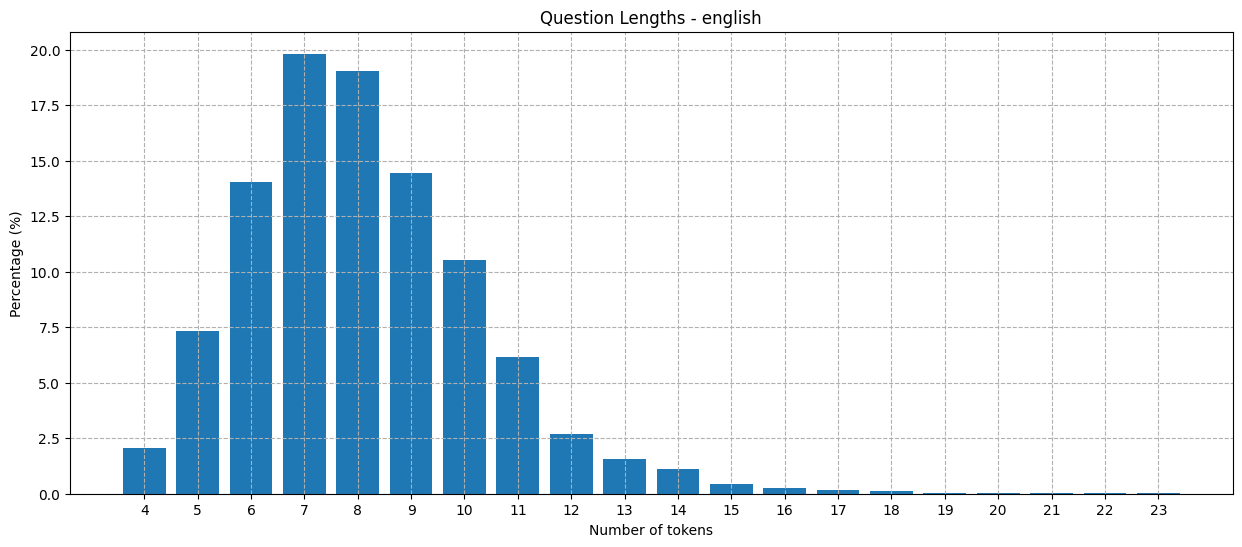

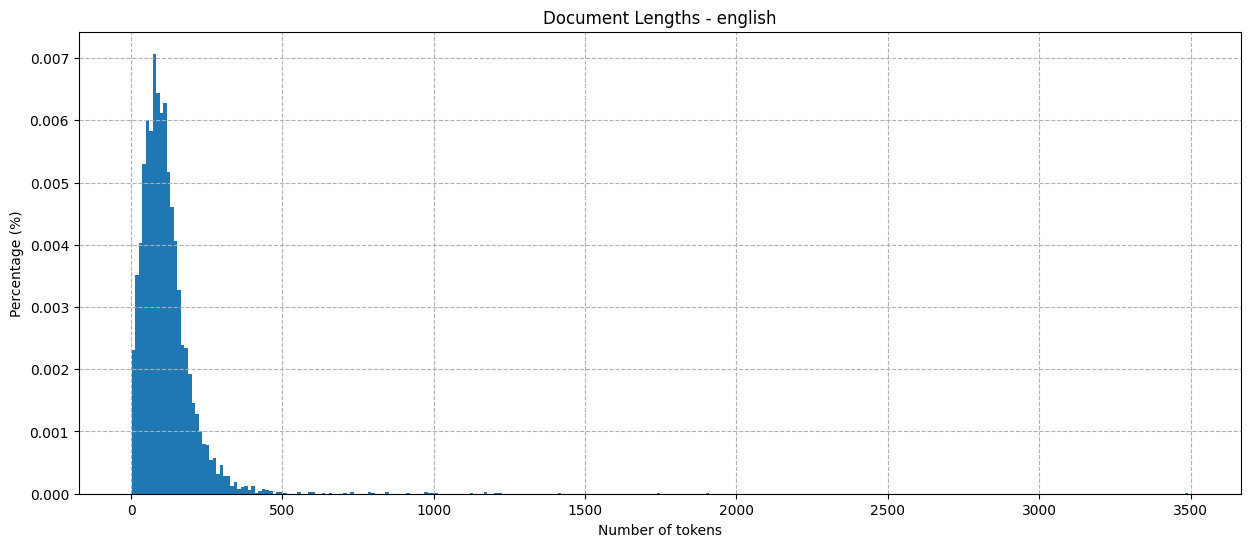

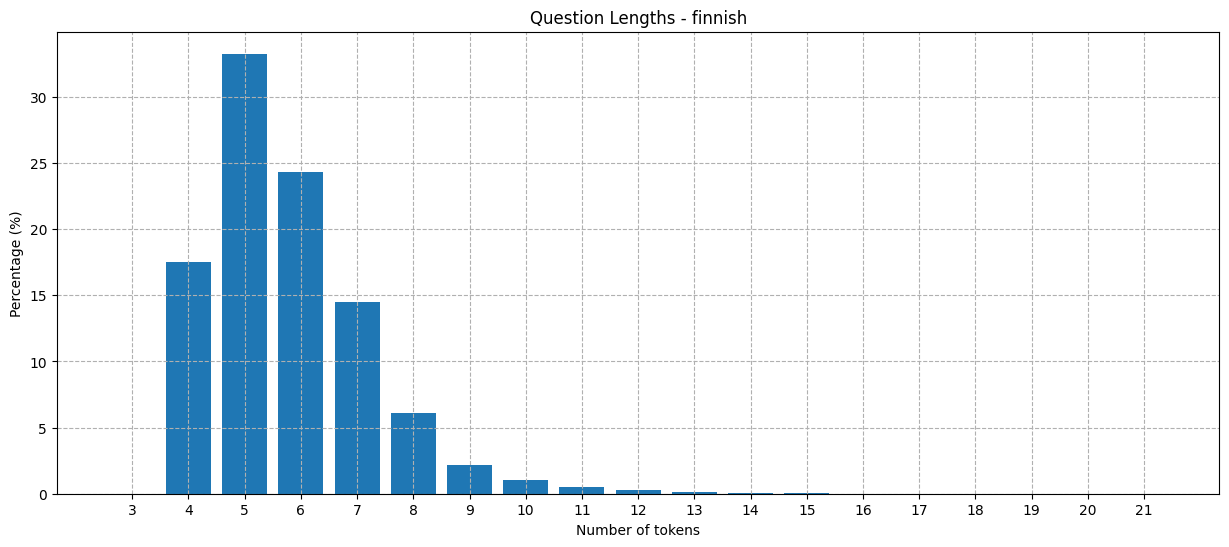

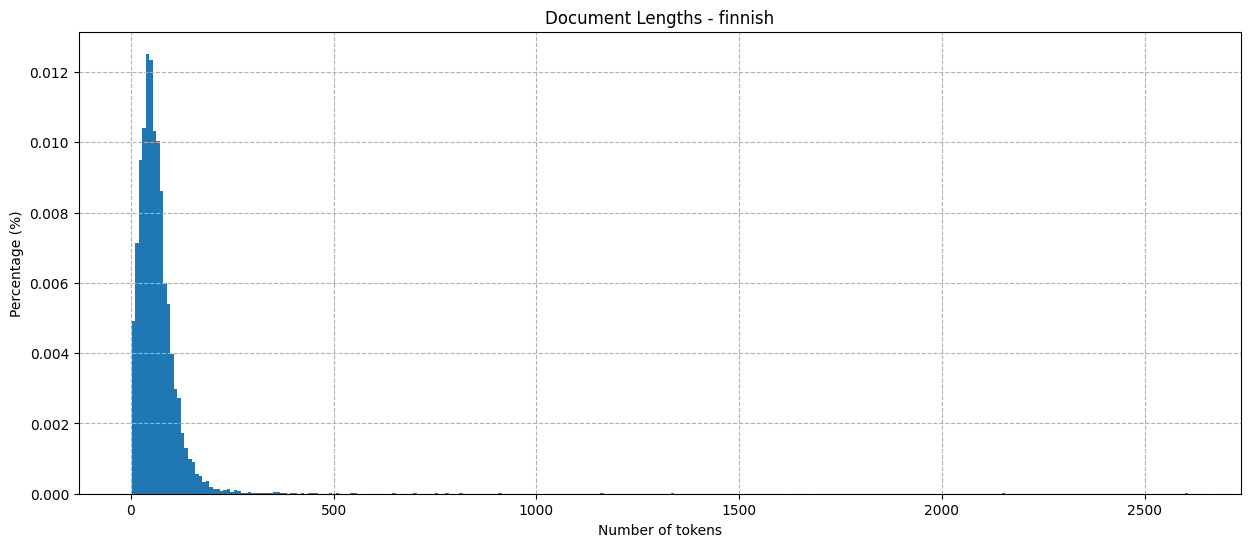

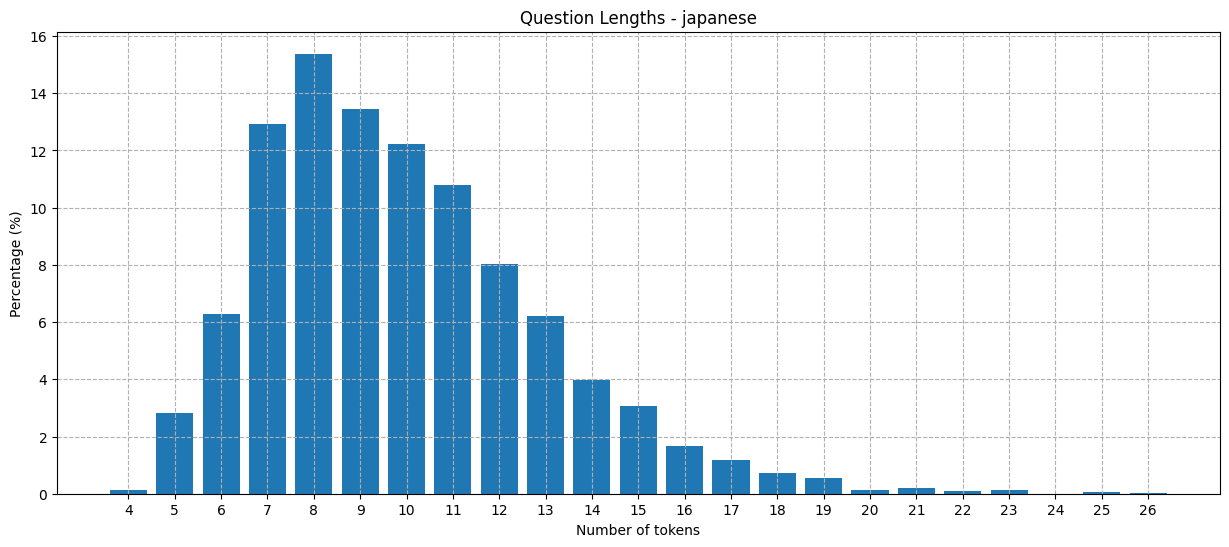

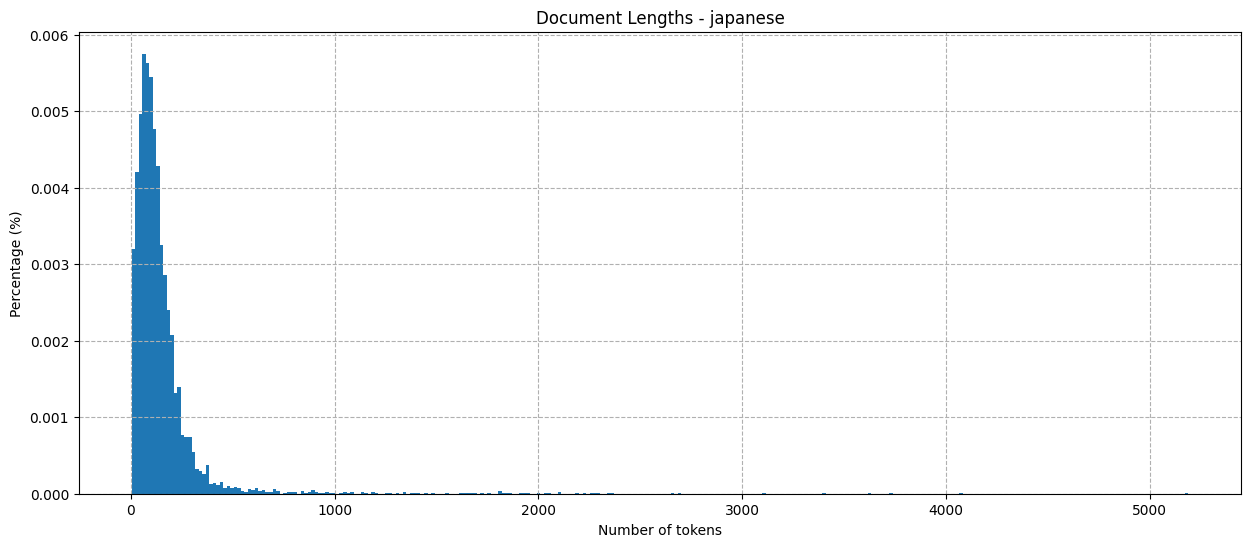

In [67]:
for language in languages:
    dataset = lang_datasets[language]
    train_set = dataset["train_set"]
    validation_set = dataset["validation_set"]
    language_full = language_code_to_language[language]

    plot_question_token_count_dist(train_set, "Question Lengths - {}".format(language_full))
    plot_document_token_count_dist(train_set, "Document Lengths - {}".format(language_full))

### Features 

@TODO: plot distribution of whether question are answered based on the start word, "How, when, Why" etc

#### Feature Used
- Bag of Words for Question tokens (some words are easier to answer, e.g. When vs How) (also with TF-IDF extension. however, no noticeable change! Actually a bit worse accuracy)
- Number of tokens in document (A longer document is more likely to have the correct answer than a short document)
- Number of tokens in question (A longer answer looks for a very specific answer)
- Answer overlap between document and text

#### Features Ignored
- BoW for the document was not included as part of the features as 1. the memory was on exhausted both on a local machine and cloud machine. 2. BoW is likely a poor feature for question-answer classifiction problems, since this problem needs sentence context, in order to determine whether the question has been answered or not.

## Q1.2a

In [74]:
def get_lexical_features_from_dataset(dataset: pd.DataFrame, token_to_id: Dict[str, int]) -> np.ndarray:
    question_BoW_per_obs         = get_bag_of_words_vector_per_observation(dataset['question'], token_to_id)
    question_token_count_per_obs = count_tokens_per_observation(dataset['question'])
    document_token_count_per_obs = count_tokens_per_observation(dataset['document'])
    token_overlap_per_obs        = count_token_overlap_per_observation(dataset['question'], dataset['document'])
    
    question_tf_idf_per_obs = transform_bag_of_word_vectors_to_TF_idf_vectors(question_BoW_per_obs)

    features = np.concatenate(
        (question_tf_idf_per_obs, 
         question_token_count_per_obs.reshape((-1,1)), 
         document_token_count_per_obs.reshape((-1,1)), 
         token_overlap_per_obs.reshape((-1,1))), 
        axis=1)

    return features

In [75]:
def get_labels_from_dataset(dataset: pd.DataFrame) -> np.ndarray:
    answer_region_column = dataset['document_answer_region']
    
    labels = np.empty(answer_region_column.shape[0], dtype=np.int32)
    for i, answer in enumerate(answer_region_column):
        labels[i] = 0 if answer == Annotation_error.UNANSWERED else 1
        
    return labels

In [76]:
def str_label_summary(y: np.ndarray) -> str:
    num_answered = np.sum(y == 1)
    num_unanswered = np.sum(y == 0)
    return "Answered questions: {}, unanswered questions: {}.".format(num_answered, num_unanswered)

## Q1.2b+c

In [77]:
def evaluate(label_pred: np.ndarray, label_true: np.ndarray):
    report = classification_report(label_true, label_pred)
    print(report)
    
    cm = confusion_matrix(label_true, label_pred) / len(label_pred) # normalize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def run_model(train_set: pd.DataFrame, validation_set: pd.DataFrame):
    token_to_id = create_token_to_id_mapping_from_token_sentences(train_set['question'])
    print("{} unique tokens".format(len(token_to_id)))
    
    X_train = get_lexical_features_from_dataset(train_set, token_to_id)
    y_train = get_labels_from_dataset(train_set)

    X_validation = get_lexical_features_from_dataset(validation_set, token_to_id)
    y_validation = get_labels_from_dataset(validation_set)

    print("Train set | " + str_label_summary(y_train))
    print("Validation set | " + str_label_summary(y_validation))

    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    y_preds = model.predict(X_validation)
    evaluate(y_preds, y_validation)
    
    return model

Let's do prediction on the validation set for each language and compute the accuracy.

In [ ]:
for language in languages:
    dataset = all_datasets[language]
    train_set = dataset["train_set"]
    validation_set = dataset["validation_set"]
    language_full = language_code_to_language[language]

    lexical_model = run_model(train_set, validation_set)
    language_models[language]["lexical_model"] = lexical_model

# 2. Representation Learning

In [93]:
def token_to_embedding_id(token, tok2vec):
    assert OOV_id != None

    try:
        id = tok2vec.get_index(token)
    except:
        id = OOV_id
        
    return id

In [94]:
def convert_token_to_word_embedding_id(tokens, tok2vec, max_length=-1):
    return [token_to_embedding_id(token, tok2vec) for token in tokens[:max_length]]

In [123]:
def pad_token_ids(token_ids_per_observation: List[List[str]]) -> List[List[str]]:
    assert pad_id != None
    
    token_count_per_observation = [len(token_ids) for token_ids in token_ids_per_observation]
    max_token_count = max(token_count_per_observation)
    
    padded_ids_per_observation = [(token_ids + [pad_id] * (max_token_count - len(token_ids))) for token_ids in token_ids_per_observation]
    
    assert (all(len(padded_ids) == max_token_count for padded_ids in padded_ids_per_observation))
    
    return padded_ids_per_observation

In [124]:
def collate_into_batch(raw_batch):
    """
    Collates a set of observations, where each observation is a list, into a 2d tensor
    """
    question_ids_per_obs        = [obs[0] for obs in raw_batch]
    question_ids_count_per_obs  = [obs[1] for obs in raw_batch]
    question_padded_ids_per_obs = pad_token_ids(question_ids_per_obs)
    
    document_ids_per_obs        = [obs[2] for obs in raw_batch]
    document_ids_count_per_obs  = [obs[3] for obs in raw_batch]
    document_padded_ids_per_obs = pad_token_ids(document_ids_per_obs)
    
    labels = [obs[4] for obs in raw_batch]

    # to tensors
    question_padded_ids_per_obs = torch.tensor(question_padded_ids_per_obs)
    question_ids_count_per_obs = torch.tensor(question_ids_count_per_obs, dtype=torch.long)
    document_padded_ids_per_obs = torch.tensor(document_padded_ids_per_obs)
    document_ids_count_per_obs = torch.tensor(document_ids_count_per_obs, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)
    
    return question_padded_ids_per_obs, question_ids_count_per_obs, document_padded_ids_per_obs, document_ids_count_per_obs, labels

## Q2A
This question is answered after Q2B actually.

## Q2b

In [125]:
class IsQuestionAnsweredDataset(Dataset):
    
    def __init__(self, dataset, tok2vec):
        self.dataset = dataset
        self.tok2vec = tok2vec
        self.labels = get_labels_from_dataset(dataset)
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.values[idx]

        question_tokens = row[1]
        document_tokens = row[3]
        
        question_ids = convert_token_to_word_embedding_id(question_tokens, tok2vec, 128)
        document_ids = convert_token_to_word_embedding_id(document_tokens, tok2vec, 1024)
        
        labels = self.labels[idx]
        
        return question_ids, len(question_ids), document_ids, len(document_ids), labels

In [126]:
class FF_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, n_classes: int = 2):
        super(FF_Network, self).__init__()
        
        self.net = nn.Sequential(
            nn.Embedding.from_pretrained(pretrained_embeddings),
            nn.Flatten(start_dim=-2),
            nn.Linear(pretrained_embeddings.shape[1]*2, 72),
            nn.ReLU(),
            nn.Linear(72, n_classes)
        )
        
    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        return self.net(q_ids)


In [127]:
class LSTM_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(LSTM_Network, self).__init__()
        
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, batch_first=True)
        self.linear = nn.Linear(2*lstm_dim, 72)
        self.relu = nn.ReLU()
        self.linear_out = nn.Linear(72, n_classes)

    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.word_embeddings(q_ids)
        lstm_out, _ = self.lstm(q_embeds)
        #q_ff_in = torch.max(lstm_out, 1)[0]
        q_ff_in = lstm_out[range(lstm_out.shape[0]), (q_lengths-1).long(), :] # last unit
        
        d_embeds = self.word_embeddings(d_ids)
        lstm_out, _ = self.lstm(d_embeds)
        d_ff_in = torch.max(lstm_out, 1)[0]
        
        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        
        x = self.linear(ff_in)
        x = self.relu(x)
        logits = self.linear_out(x)

        return logits


In [128]:
class BiLSTM_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(BiLSTM_Network, self).__init__()

        self.lstm_dim = lstm_dim
        self.n_classes = n_classes
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1)
        self.biLSTM = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, 1, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2*2*lstm_dim, n_classes)
        self.relu = nn.ReLU()
        
    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.embedding(q_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(q_embeds, q_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        #q_ff_in = torch.max(lstm_out, 1)[0]
        q_ff_in = lstm_out[range(lstm_out.shape[0]), (q_lengths-1).long(), :] # last unit

        d_embeds = self.embedding(d_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(d_embeds, d_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        d_ff_in = torch.max(lstm_out, 1)[0]

        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        ff_in = self.relu(ff_in)
        logits = self.linear(ff_in)
        
        return logits

In [129]:
class Attentive_LSTM_Network(nn.Module):

    # @TODO Bi!
    def __init__(self, pretrained_embeddings: torch.tensor, n_classes: int = 2):
        super(Attentive_LSTM_Network, self).__init__()

        self.lstm_and_attention_dim = pretrained_embeddings.shape[1]
        self.n_classes = n_classes

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1)
        self.q_biLSTM = nn.LSTM(pretrained_embeddings.shape[1], self.lstm_and_attention_dim, 1, batch_first=True, bidirectional=False)
        self.doc_biLSTM = nn.LSTM(pretrained_embeddings.shape[1], self.lstm_and_attention_dim, 1, batch_first=True, bidirectional=False)
        self.doc_attention = torchnlp.nn.Attention(self.lstm_and_attention_dim)
        self.linear = nn.Linear(2*self.lstm_and_attention_dim, n_classes)
        
    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.embedding(q_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(q_embeds, q_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.q_biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        #q_ff_in = torch.max(lstm_out, 1)[0] # hidden unit with max value
        q_ff_in = lstm_out[range(lstm_out.shape[0]), (q_lengths-1).long(), :] # last unit

        d_embeds = self.embedding(d_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(d_embeds, d_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.doc_biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        d_ff_in, weights = self.doc_attention(q_ff_in[:, None, :], lstm_out)
        d_ff_in = d_ff_in[:,0,:] # only 1 query so extract that

        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        logits = self.linear(ff_in)
        
        return logits

In [130]:
def prepare_embedding_matrix(embed_matrix: np.ndarray):
    embed_dim = embed_matrix.shape[1]
    
    pad_embedding = torch.zeros(embed_dim, dtype=torch.float32)
    OOV_embedding = torch.zeros(embed_dim, dtype=torch.float32)
    
    embed_pre = torch.tensor(embed_matrix, dtype=torch.float32)
    
    OOV_id = embed_pre.shape[0]           
    pad_id = embed_pre.shape[0] + 1
                 
    return torch.vstack((embed_pre, pad_embedding, OOV_embedding)), pad_id, OOV_id

In [131]:
def test_forward_pass(model: nn.Module):
    """
    A simple function to quickly debug the net
    """
    # Test the forward pass with dummy data
    q = torch.tensor([[42, 1, 8, 0]], dtype=torch.int).to(device)
    q_lengths = torch.tensor([3], dtype=torch.int).to(device)
    d = torch.tensor([[42, 1, 8, 0]], dtype=torch.int).to(device)
    d_lengths = torch.tensor([3], dtype=torch.int).to(device)

    out = model.forward(q, q_lengths, d, d_lengths)

    print("Output shape:", out.size())
    print(f"Output logits:\n{out.cpu().detach().numpy()}")

In [132]:
def summarize_batch(q_ids, q_lengths, d_ids, d_lengths):
    assert pad_id != None

    ### question
    actual_length = torch.sum(q_lengths)
    total_length = np.sum([len(question) for question in q_ids])
    
    print("### Question ###")

    OOV_count = np.sum([torch.sum(question == OOV_id) for question in q_ids])
    print("OOV: {}/{} {:.2f}%".format(OOV_count, total_length, OOV_count / total_length * 100.))
    
    pad_count = np.sum([torch.sum(question == pad_id) for question in q_ids])
    print("PAD: {}/{} {:.2f}%".format(pad_count, total_length, pad_count / total_length * 100.))

    ## document
    actual_length = torch.sum(d_lengths)
    total_length = np.sum([len(question) for question in d_ids])
    
    print("\n### Document ###")

    OOV_count = np.sum([torch.sum(ids == OOV_id) for ids in d_ids])
    print("OOV: {}/{} {:.2f}%".format(OOV_count, total_length, OOV_count / total_length * 100.))
    
    pad_count = np.sum([torch.sum(ids == pad_id) for ids in d_ids])
    print("PAD: {}/{} {:.2f}%".format(pad_count, total_length, pad_count / total_length * 100.))   
    

In [133]:
tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("resources/fasttext-en-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())
train_dataset = IsQuestionAnsweredDataset(lang_datasets["en"]["train_set"], tok2vec)

In [ ]:
type(train_dataset)

In [134]:
def batchify(dataset):
    """Turns a list of samples into a tensor of samples"""
    return collate_into_batch([sample for sample in dataset])

In [135]:
collated = batchify(train_dataset)
q_ids, q_lengths, d_ids, d_lengths, _ = collated

In [136]:
summarize_batch(q_ids, q_lengths, d_ids, d_lengths)

### Question ###
OOV: 5015/169947 2.95%
PAD: 109954/169947 64.70%

### Document ###
OOV: 84749/7566336 1.12%
PAD: 6718604/7566336 88.80%


In [137]:
def transfer_batch(q_ids, q_lengths, d_ids, d_lengths, targets, device):
    q_ids     = q_ids.to(device)
    q_lengths = q_lengths.to(device)
    d_ids     = d_ids.to(device)
    d_lengths = d_lengths.to(device)
    targets   = targets.to(device)
    return q_ids, q_lengths, d_ids, d_lengths, targets     

In [138]:
def train(model: nn.Module, tok2vec, train_data, validation_data, n_epochs = 15, batch_size = 64, weight_decay=1e-6):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)

    # Load dataset
    # train_data.iloc[3690:3700]
    train_dataset = IsQuestionAnsweredDataset(train_data, tok2vec)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_into_batch)

    val_dataset = IsQuestionAnsweredDataset(validation_data, tok2vec)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_into_batch)

    # store improvement per epoch
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(n_epochs):

        ### Training
        model.train()

        # Store batch loss and accuracy
        loss_epoch = []
        accuracy_epoch = []

        batch_pbar = tqdm(train_dataloader)
        for batch in batch_pbar:
            q_ids, q_lengths, d_ids, d_lengths, targets = transfer_batch(*batch, device)
            
            optimizer.zero_grad()
            
            # training
            outputs = model(q_ids, q_lengths, d_ids, d_lengths)
            loss = loss_fn(outputs, targets)

            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()

            # prediction
            predictions = outputs.detach().cpu().max(1)[1]
            accuracy = accuracy_score(targets.detach().cpu(), predictions)

            loss_epoch.append(loss.detach().cpu().item())
            accuracy_epoch.append(accuracy)

            batch_pbar.set_description(f"epoch={epoch+1}/{n_epochs} | loss={loss.item():.2f}, accuracy={accuracy:.2f}")

        train_loss = np.mean(loss_epoch)
        train_losses.append(train_loss)

        train_acc = np.mean(accuracy_epoch)
        train_accuracies.append(train_acc)

        ### Evaluation
        test_acc = evaluate_inplace(model, val_dataloader)
        test_accuracies.append(test_acc)

        print(f"epoch={epoch+1}/{n_epochs} | loss={train_loss:.2f}, train_accuracy={train_acc:.2f}, test_accuracy={test_acc:.2f}")

    print("Finished training.")
    
    return train_losses, train_accuracies, test_accuracies

In [139]:
def evaluate_inplace(model: nn.Module, valid_dl: DataLoader):
    model.eval()

    logits_all = []
    targets_all = []

    with torch.no_grad():
        for batch in valid_dl:
            q_ids, q_lengths, d_ids, d_lengths, targets = transfer_batch(*batch, device)

            logits = model(q_ids, q_lengths, d_ids, d_lengths)

            targets_all.extend(targets.detach().cpu().numpy())

            predictions = logits.max(1)[1].cpu()
            logits_all.extend(predictions)
            
        acc = accuracy_score(logits_all, targets_all)

    return acc

In [140]:
def plot_network_learning(model_name, train_accuracies, test_accuracies, train_losses=None):
    fig, ax = plt.subplots(figsize=(6,6))
    
    ax.grid(linestyle="--")
    ax.set_title(model_name)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")

    epoch_range = np.arange(len(train_accuracies), step=1)
    ax.plot(epoch_range, train_accuracies)
    ax.plot(epoch_range, test_accuracies)
    ax.legend(["Train Accuracy", "Validation Accuracy"], loc="upper left")
    
    ax.set_yticks(np.linspace(0.5, 1, 11))
    ax.set_xticks(epoch_range)
    
    if train_losses != None:
        ax2 = ax.twinx()
        ax2.plot(epoch_range, train_losses, c="g")
        ax2.set_yticks(np.linspace(0, 1, 11))
        ax2.set_ylabel("Loss")
        ax2.legend(["Train Loss"], loc="upper right")

In [141]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [142]:
device

device(type='cpu')

In [144]:
def get_tok2vec(path: str):
    return compress_fasttext.models.CompressedFastTextKeyedVectors.load(path)

In [145]:
def train_embedding_model(lang, weight_decay=1e-6):
    # Setup Model
    tok2vec = get_tok2vec("resources/fasttext-{}-mini".format(lang))
    pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())

    embedding_model = BiLSTM_Network(pretrained_embeddings)
    embedding_model.to(device)

    print(embedding_model)

    #test_forward_pass(embedding_model)

    language_models[lang]["embedding_model"] = embedding_model

    train_result = train(embedding_model, tok2vec, lang_datasets[lang]["train_set"], lang_datasets[lang]["validation_set"], weight_decay=weight_decay, n_epochs=1000)

    return train_result

## English

In [146]:
train_result = train_embedding_model("en")

BiLSTM_Network(
  (embedding): Embedding(20002, 300, padding_idx=20001)
  (biLSTM): LSTM(300, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=400, out_features=2, bias=True)
  (relu): ReLU()
)


epoch=1/1000 | loss=0.47, accuracy=0.75:  45%|█████████████████▉                      | 52/116 [10:14<12:36, 11.82s/it]


KeyboardInterrupt: 

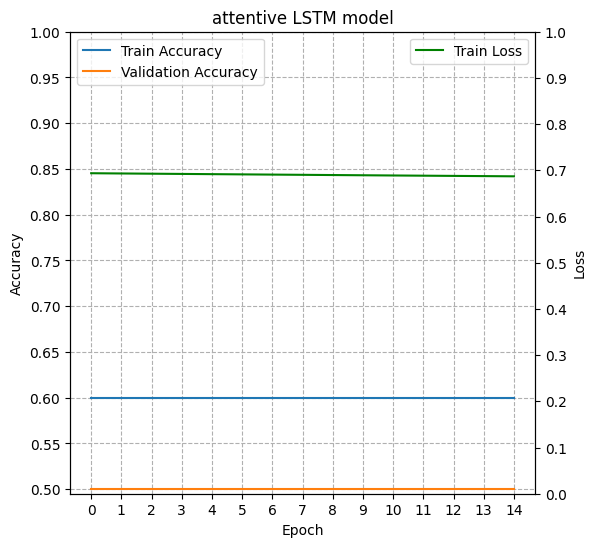

In [ ]:
train_losses, train_accuracies, test_accuracies = train_result
plot_network_learning("attentive LSTM model", train_accuracies, test_accuracies, train_losses)

## Finnish

In [ ]:
train_result = train_embedding_model("fi")

Attentive_LSTM_Network(
  (embedding): Embedding(20002, 300, padding_idx=20001)
  (q_biLSTM): LSTM(300, 300, batch_first=True)
  (doc_biLSTM): LSTM(300, 300, batch_first=True)
  (doc_attention): Attention(
    (linear_in): Linear(in_features=300, out_features=300, bias=False)
    (linear_out): Linear(in_features=600, out_features=300, bias=False)
    (softmax): Softmax(dim=-1)
    (tanh): Tanh()
  )
  (linear): Linear(in_features=600, out_features=2, bias=True)
)


epoch=1/15 | loss=0.61, accuracy=0.80: 100%|██████████| 215/215 [00:09<00:00, 22.31it/s]


epoch=1/15 | loss=0.68, train_accuracy=0.57, test_accuracy=0.64


epoch=2/15 | loss=0.40, accuracy=1.00: 100%|██████████| 215/215 [00:09<00:00, 22.74it/s]


epoch=2/15 | loss=0.60, train_accuracy=0.67, test_accuracy=0.65


epoch=3/15 | loss=0.73, accuracy=0.60: 100%|██████████| 215/215 [00:09<00:00, 22.43it/s]


epoch=3/15 | loss=0.57, train_accuracy=0.68, test_accuracy=0.66


epoch=4/15 | loss=0.47, accuracy=0.80: 100%|██████████| 215/215 [00:09<00:00, 22.64it/s]


epoch=4/15 | loss=0.56, train_accuracy=0.69, test_accuracy=0.67


epoch=5/15 | loss=0.28, accuracy=1.00: 100%|██████████| 215/215 [00:09<00:00, 22.44it/s]


epoch=5/15 | loss=0.56, train_accuracy=0.69, test_accuracy=0.66


epoch=6/15 | loss=0.56, accuracy=0.60: 100%|██████████| 215/215 [00:09<00:00, 22.61it/s]


epoch=6/15 | loss=0.55, train_accuracy=0.70, test_accuracy=0.68


epoch=7/15 | loss=0.56, accuracy=0.40: 100%|██████████| 215/215 [00:09<00:00, 22.36it/s]


epoch=7/15 | loss=0.55, train_accuracy=0.69, test_accuracy=0.67


epoch=8/15 | loss=0.80, accuracy=0.40: 100%|██████████| 215/215 [00:09<00:00, 22.73it/s]


epoch=8/15 | loss=0.55, train_accuracy=0.69, test_accuracy=0.69


epoch=9/15 | loss=0.93, accuracy=0.60: 100%|██████████| 215/215 [00:09<00:00, 22.65it/s]


epoch=9/15 | loss=0.54, train_accuracy=0.70, test_accuracy=0.69


epoch=10/15 | loss=0.56, accuracy=0.66:   5%|▌         | 11/215 [00:00<00:11, 17.15it/s]


KeyboardInterrupt: ignored

In [ ]:
train_losses, train_accuracies, test_accuracies = train_result
plot_network_learning("biLSTM model", train_accuracies, test_accuracies, train_losses)

## Japanese

In [ ]:
train_result = train_embedding_model("ja")

In [ ]:
train_losses, train_accuracies, test_accuracies = train_result
plot_network_learning("LSTM model", train_accuracies, test_accuracies, train_losses)

## Q2A

In [ ]:
def predict_with_combined_model(lexical_model, embedding_model: nn.Module, token_to_id_vocab, dataset, tok2vec):
    
    # Prepare datasets
    X_lexical = get_lexical_features_from_dataset(dataset, token_to_id_vocab)

    embedding_dataset = IsQuestionAnsweredDataset(dataset, tok2vec)
    X_embedding = batchify(embedding_dataset)
    
    # Prediction for each
    y_lexical = lexical_model.predict_proba(X_lexical)
    
    embedding_model.eval()
    with torch.no_grad():
        q_ids, q_lengths, d_ids, d_lengths, _ = transfer_batch(*X_embedding, device)
        logits = embedding_model(q_ids, q_lengths, d_ids, d_lengths)
        y_embedding = nn.functional.softmax(logits, dim=1).cpu().numpy()
    
    # Combined prediction
    y_combined = y_lexical * y_embedding
    combined_predictions = y_combined.argmax(axis=1)

    return combined_predictions




### Evaluation for en ###
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       495
           1       0.82      0.73      0.77       495

    accuracy                           0.78       990
   macro avg       0.79      0.78      0.78       990
weighted avg       0.79      0.78      0.78       990



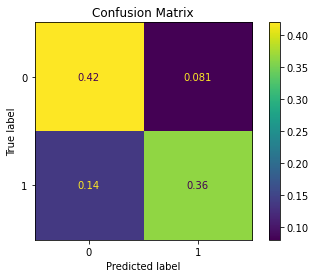




### Evaluation for fi ###
              precision    recall  f1-score   support

           0       0.58      0.86      0.69       843
           1       0.72      0.38      0.50       843

    accuracy                           0.62      1686
   macro avg       0.65      0.62      0.59      1686
weighted avg       0.65      0.62      0.59      1686



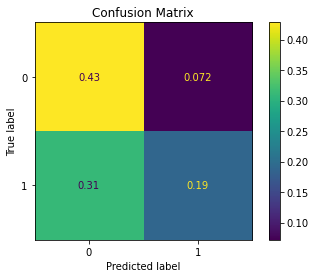




### Evaluation for ja ###
              precision    recall  f1-score   support

           0       0.51      0.92      0.65       518
           1       0.58      0.11      0.18       518

    accuracy                           0.51      1036
   macro avg       0.54      0.51      0.42      1036
weighted avg       0.54      0.51      0.42      1036



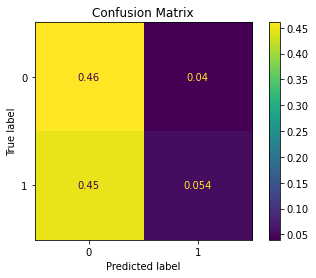

In [ ]:
for language in languages:
    train_set = lang_datasets[language]["train_set"]
    validation_set = lang_datasets[language]["validation_set"]
    token_to_id_vocab = 
    
    
    (train_set["question"])
    lexical_model = language_models[language]["lexical_model"]
    embedding_model = language_models[language]["embedding_model"]
    tok2vec = get_tok2vec("resources/fasttext-{}-mini".format(language))
    
    y_pred = predict_with_combined_model(lexical_model, embedding_model, token_to_id_vocab, validation_set, tok2vec)
    y_true = get_labels_from_dataset(validation_set)

    print("\n\n\n### Evaluation for {} ###".format(language))
    evaluate(y_pred, y_true)